In [27]:
import nptsne
from nptsne import hsne_analysis
from pathlib import Path
import numpy as np
import community as community_louvain
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from tqdm import tqdm
from sklearn.utils import check_random_state, check_array


fashionTrain = pd.read_csv('data/fashion-train.csv')

fashionX = fashionTrain.values[:,2:]
fashionY = fashionTrain.values[:, 1].astype(int)

print(fashionX.shape, fashionY.shape)

X = fashionX
lab = fashionY.astype(int)
X = check_array(X, dtype=np.float32, accept_sparse="csr", order="C")

# X = np.load('./data/MNIST_70000.npy')
# lab = np.load('./data/MNIST_70000_label.npy').astype(int)
print('Size data:', X.shape)
hsne = nptsne.HSne(True)
# Create a 3 scale HSNE analysis from the MNIST data
hsne.create_hsne(X, 3)
print(hsne.get_scale(0).num_points, hsne.get_scale(1).num_points, hsne.get_scale(2).num_points)

(60000, 784) (60000,)
Size data: (60000, 784)
60000 11249 1976


In [28]:
container = hsne_analysis.AnalysisModel(hsne, hsne_analysis.EmbedderType.GPU)

In [29]:
# temp.initialize_embedding(temp.)
analysis_level2 = container.top_analysis
len(analysis_level2.landmark_orig_indexes), analysis_level2.landmark_orig_indexes

(1976, array([   10,    26,    59, ..., 59914, 59984, 59993], dtype=uint32))

In [30]:
for i in tqdm(range(500)):
    analysis_level2.do_iteration()

100%|██████████| 500/500 [00:00<00:00, 1300.97it/s]


In [31]:
y_analysis_level2 = lab[analysis_level2.landmark_orig_indexes]
y_analysis_level2

array([0, 4, 4, ..., 4, 7, 2])

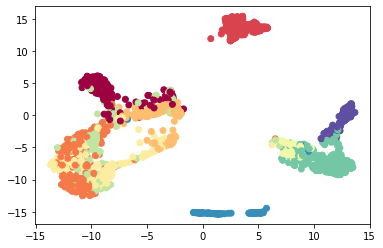

In [32]:
plt.scatter(analysis_level2.embedding[:, 0], analysis_level2.embedding[:, 1], c = y_analysis_level2, cmap='Spectral')
plt.savefig("hsne_level2.svg")
plt.show()

In [33]:
analysis_level1 = container.add_new_analysis(analysis_level2, np.arange(len(y_analysis_level2)))
len(analysis_level1.landmark_orig_indexes), analysis_level1.landmark_orig_indexes

(11249, array([    6,     8,     9, ..., 59984, 59985, 59993], dtype=uint32))

In [34]:
for i in tqdm(range(500)):
    analysis_level1.do_iteration()

100%|██████████| 500/500 [00:00<00:00, 519.04it/s]


In [35]:
y_analysis_level1 = lab[analysis_level1.landmark_orig_indexes]
y_analysis_level1

array([4, 4, 8, ..., 7, 6, 2])

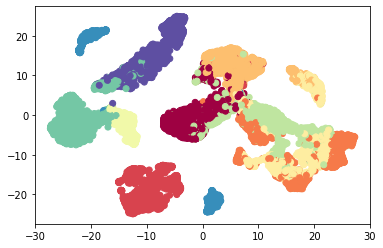

In [36]:
plt.scatter(analysis_level1.embedding[:, 0], analysis_level1.embedding[:, 1], c = y_analysis_level1, cmap='Spectral')
plt.savefig("hsne_level1.svg")
plt.show()

In [37]:
analysis_level0 = container.add_new_analysis(analysis_level1, np.arange(len(y_analysis_level1)))
len(analysis_level0.landmark_orig_indexes), analysis_level0.landmark_orig_indexes

(60000, array([    0,     1,     2, ..., 59997, 59998, 59999], dtype=uint32))

In [38]:
for i in tqdm(range(500)):
    analysis_level0.do_iteration()

100%|██████████| 500/500 [00:03<00:00, 162.48it/s]


In [39]:
y_analysis_level0 = lab[analysis_level0.landmark_orig_indexes]
y_analysis_level0

array([2, 9, 6, ..., 8, 8, 7])

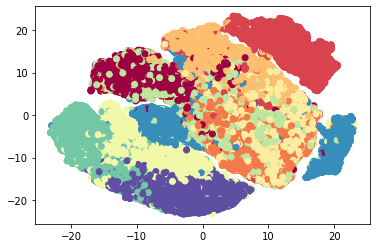

In [40]:
plt.scatter(analysis_level0.embedding[:, 0], analysis_level0.embedding[:, 1], c = y_analysis_level0, cmap='Spectral')
plt.savefig("hsne_level0.svg")
plt.show()

In [41]:
indices = []
for i in range(len(y_analysis_level2)):
    if y_analysis_level2[i] in [5,7,9]:
        indices.append(i)


analysis_cluster = container.add_new_analysis(analysis_level2, np.array(indices))
len(analysis_cluster.landmark_orig_indexes), analysis_cluster.landmark_orig_indexes

(3274, array([  130,   156,   171, ..., 59974, 59979, 59984], dtype=uint32))

In [42]:
for i in tqdm(range(500)):
    analysis_cluster.do_iteration()

100%|██████████| 500/500 [00:00<00:00, 956.51it/s]


In [43]:
y_analysis_cluster = lab[analysis_cluster.landmark_orig_indexes]
y_analysis_cluster

array([7, 7, 9, ..., 7, 5, 7])

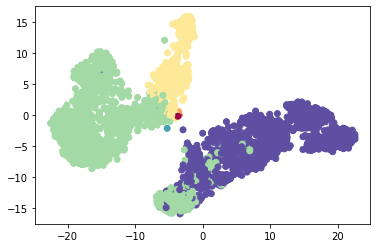

In [44]:
plt.scatter(analysis_cluster.embedding[:, 0], analysis_cluster.embedding[:, 1], c = y_analysis_cluster, cmap='Spectral')
plt.savefig("hsne_drilling_down.svg")
plt.show()

In [45]:
import demap
from sklearn.neighbors import NearestNeighbors

def NNP(X, X_emb, Khigh=30):
    neigh_high = NearestNeighbors(n_neighbors=Khigh, n_jobs=-1)
    neigh_high.fit(X)
    high_dists, high_indices = neigh_high.kneighbors(X)


    neigh_emb = NearestNeighbors(n_neighbors=Khigh, n_jobs=-1)
    neigh_emb.fit(X_emb)
    emb_dists, emb_indices = neigh_emb.kneighbors(X_emb)

    m_precision = np.zeros(Khigh)
    m_recall = np.zeros(Khigh)
    
    for i in tqdm(range(X.shape[0])):
        high_current = high_indices[i][1:]
        for k in range(1, Khigh+1):
            emb_current = emb_indices[i][1:k+1]            
            
            tp = len(np.intersect1d(high_current, emb_current))
            
            precision_val = float(tp)/k
            recall_val = float(tp)/Khigh
            
            m_precision[k-1] += precision_val
            m_recall[k-1] += recall_val
    
    m_precision = m_precision/float(X.shape[0])
    m_recall = m_recall/float(X.shape[0])
    
            
    return m_precision, m_recall


def neighborhood_preservation(X, X_emb, Khigh=30):
    
    neigh_high = NearestNeighbors(n_neighbors=Khigh+1, n_jobs=-1)
    neigh_high.fit(X)
    high_dists, high_indices = neigh_high.kneighbors(X)


    neigh_emb = NearestNeighbors(n_neighbors=Khigh+1, n_jobs=-1)
    neigh_emb.fit(X_emb)
    emb_dists, emb_indices = neigh_emb.kneighbors(X_emb)

    npres = np.zeros(Khigh)
    
    for k in range(1, Khigh+1):
        for i in range(X.shape[0]):
            high_current = high_indices[i][1:k+1]
            emb_current = emb_indices[i][1:k+1]
            
            tp = len(np.intersect1d(high_current, emb_current))
            
            npres[k-1] += (tp/k)
        
        
    npres /= float(X.shape[0])
    
    return npres
    
    


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (3274, 784) is expensive. Consider setting n_pca.
  UserWarning,


0.8361721605634066
[0.0772755  0.12339646 0.15556913 0.18547648 0.20952963 0.23289554
 0.25194171 0.26805895 0.28303808 0.2990226  0.31171211 0.3239157
 0.33497016 0.34475085 0.35489717 0.36394701 0.37186029 0.37926763
 0.38714915 0.39415089 0.40150391 0.40843839 0.41414571 0.42000102
 0.42623091 0.4321108  0.43761171 0.44265425 0.44716997 0.45203625]


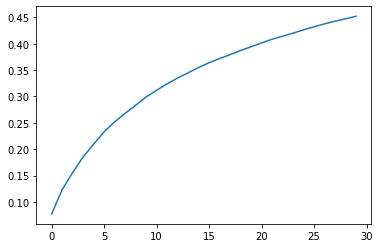

In [46]:
cluster_level = X[analysis_cluster.landmark_orig_indexes,:]
cluster_embedding = analysis_cluster.embedding

print(demap.DEMaP(cluster_level, cluster_embedding))

ks = 30

npres = neighborhood_preservation(cluster_level, cluster_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.show()


pd_drilling = pd.DataFrame({
    'hsne': npres
})
pd_drilling.to_csv("hsne_drilling.csv", index=False)

In [47]:

third_level = X[analysis_level2.landmark_orig_indexes,:]
third_embedding = analysis_level2.embedding
# precision3, recall3 = NNP(third_level, third_embedding, Khigh=30)
# plt.plot(precision3, recall3)
# plt.show()
# print(recall3[:10])
# print(precision3[:10])

In [48]:
demap.DEMaP(third_level, third_embedding)

/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (1976, 784) is expensive. Consider setting n_pca.
  UserWarning,


0.6295917603390113

[0.09868421 0.17206478 0.22098516 0.25999494 0.29423077 0.32160931
 0.34550318 0.37164727 0.3918691  0.4083502  0.42321494 0.43927126
 0.45281844 0.46580393 0.47766532 0.4890878  0.49895809 0.50916554
 0.52034946 0.53064271 0.53985926 0.54745583 0.55489791 0.5615722
 0.56868421 0.574782   0.58059679 0.58778557 0.59330937 0.59809379]


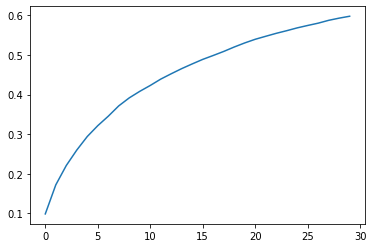

In [49]:
ks = 30

npres = neighborhood_preservation(third_level, third_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.show()

pd_level2 = pd.DataFrame({
    'hsne': npres
})
pd_level2.to_csv("hsne_level2.csv", index=False)

[0.08676327 0.13921237 0.17518594 0.20346253 0.2270424  0.24977035
 0.26830321 0.28531425 0.30133049 0.31593919 0.32851405 0.34165259
 0.35284504 0.36370217 0.37394731 0.3841397  0.39331601 0.40175423
 0.40937908 0.41681038 0.42325879 0.42954121 0.43575274 0.44172815
 0.44760957 0.45355827 0.45877988 0.46393965 0.46882328 0.47335763]


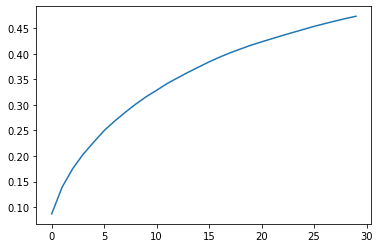

In [50]:

second_level = X[analysis_level1.landmark_orig_indexes,:]
second_embedding = analysis_level1.embedding
npres = neighborhood_preservation(second_level, second_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.show()
# precision2, recall2 = NNP(second_level, second_embedding, Khigh=30)
# plt.plot(precision2, recall2)
# plt.show()

pd_level1 = pd.DataFrame({
    'hsne': npres
})
pd_level1.to_csv("hsne_level1.csv", index=False)

In [51]:
demap.DEMaP(second_level, second_embedding)

/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (11249, 784) is expensive. Consider setting n_pca.
  UserWarning,


0.5874433278908532